#**Klasifikasi Ekspresi Wajah Menggunakan Model Convolutional Neural Network (CNN)**

##**Packages (Setup)**

Berikut daftar library yang kami gunakan untuk mengklasifikasi jenis ekspresi manusia/orang menggunakan *Convolutional Neural Network* (CNN).

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pathlib
import tensorflow as tf

from PIL import Image
from matplotlib.image import imread
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

##**Dataset**

Dataset ini diperoleh dari Kaggle https://www.kaggle.com/datasets/denisleu/facial-expressions-happiness-sadness-surprise

Dataset ini merupakan data **3 jenis ekspresi orang/manusia**, yakni sedih (sad), senang (*happy*), dan kaget (*surprise*).

In [ ]:
# Upload Dataset
from google.colab import files
uploaded = files.upload()

Saving expressions_dataset.zip to expressions_dataset.zip


In [ ]:
# Unzip dataset yang sudah di upload
!unzip -q expressions_dataset.zip -d dataset

In [ ]:
# Mendefinisikan path dari data train dan data test
train_path = 'dataset/Face Expressions (Happy, Sad, Surprise)/train'
test_path = 'dataset/Face Expressions (Happy, Sad, Surprise)/test'
subfolders = ['happy', 'sad', 'surprise']

In [ ]:
# Menghitung jumlah image yang ada pada Data Train
train_image_counts = {}
train_total = 0

for subfolder in subfolders:
    subfolder_path_train = os.path.join(train_path, subfolder)
    num_images_train = len(os.listdir(subfolder_path_train))
    train_image_counts[subfolder] = num_images_train
    train_total += num_images_train

print("Jumlah image pada data train:", train_total)
for subfolder, count in train_image_counts.items():
    print(f"Jumlah image pada subfolder '{subfolder}': {count}")

Jumlah image pada data train: 3423
Jumlah image pada subfolder 'happy': 1343
Jumlah image pada subfolder 'sad': 1072
Jumlah image pada subfolder 'surprise': 1008


In [ ]:
# Menghitung jumlah image yang ada pada Data Test
test_image_counts = {}
test_total = 0

for subfolder in subfolders:
    subfolder_path_test = os.path.join(test_path, subfolder)
    num_images_test = len(os.listdir(subfolder_path_test))
    test_image_counts[subfolder] = num_images_test
    test_total += num_images_test

print("Jumlah image pada data test:", test_total)
for subfolder, count in test_image_counts.items():
    print(f"Jumlah image pada subfolder '{subfolder}': {count}")

Jumlah image pada data test: 266
Jumlah image pada subfolder 'happy': 92
Jumlah image pada subfolder 'sad': 93
Jumlah image pada subfolder 'surprise': 81


Berikut contoh gambar dari ekspresi happy (senang):

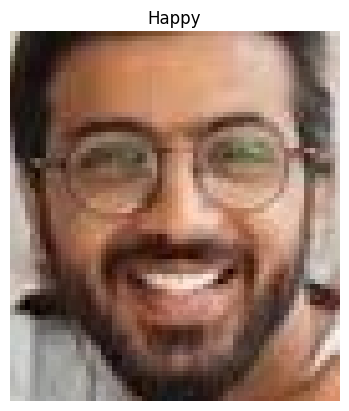

In [ ]:
happy_path = 'dataset/Face Expressions (Happy, Sad, Surprise)/test/happy'
image_files = os.listdir(happy_path)

random_image = os.path.join(happy_path, image_files[0])
image = imread(random_image)

plt.imshow(image)
plt.title('Happy')
plt.axis('off')
plt.show()

Berikut contoh gambar dari ekspresi sedih (sad):

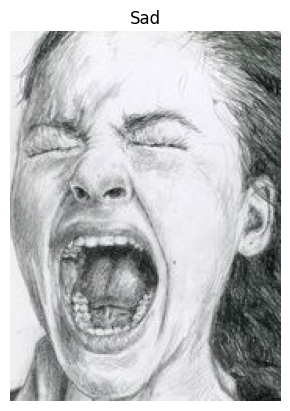

In [ ]:
sad_path = 'dataset/Face Expressions (Happy, Sad, Surprise)/test/sad'
image_files = os.listdir(sad_path)

random_image = os.path.join(sad_path, image_files[0])
image = imread(random_image)

plt.imshow(image)
plt.title('Sad')
plt.axis('off')
plt.show()

Berikut contoh gambar dari ekspresi kaget (surprise):

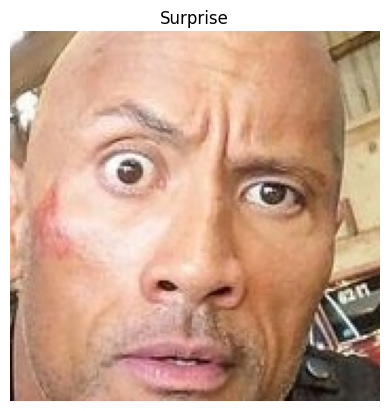

In [ ]:
surprise_path = 'dataset/Face Expressions (Happy, Sad, Surprise)/test/surprise'
image_files = os.listdir(surprise_path)

random_image = os.path.join(surprise_path, image_files[0])
image = imread(random_image)

plt.imshow(image)
plt.title('Surprise')
plt.axis('off')
plt.show()

##**Data Splitting**

Dataset akan dibagi menjadi **80% untuk training dan 20% validation**. Selain itu, didefinisikan juga beberapa parameter, seperti batch_size, img_height, img_width, agar semua gambar memiliki skala yang sama.

In [ ]:
batch_size = 32
img_height = 180 # Tinggi gambar (ukuran)
img_width = 180 # Lebar gambar (ukuran)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3423 files belonging to 3 classes.
Using 2739 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3423 files belonging to 3 classes.
Using 684 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['happy', 'sad', 'surprise']


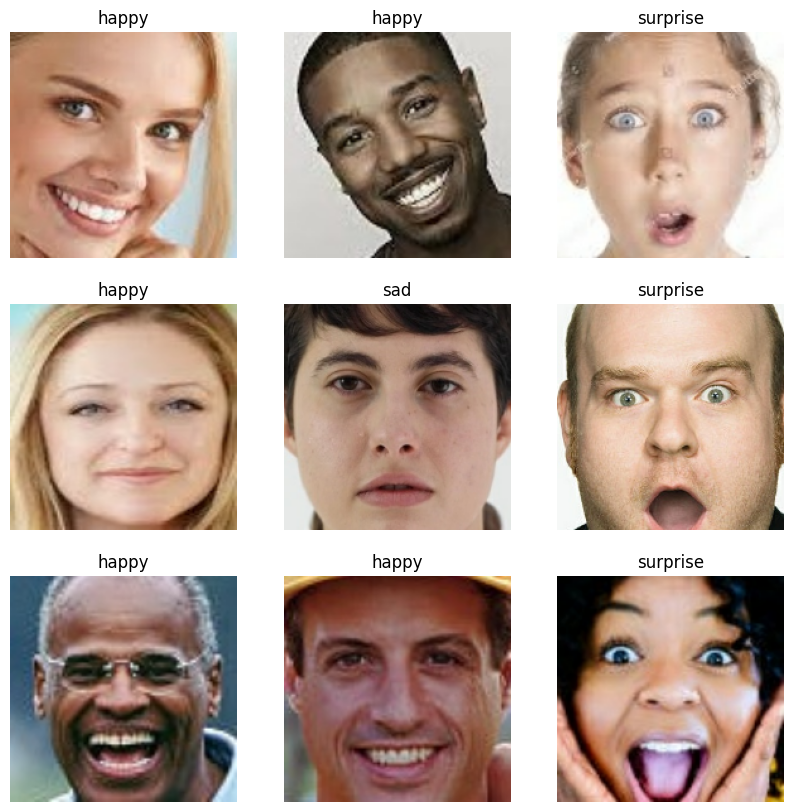

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Berikut cara untuk memastikan ukuruan pada gambar yang akan dimasukkan ke model nantinya:

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Untuk mempersiapkan dan mengoptimalkan "data train" dan "data validasi", kita perlu menggunakan *buffered prefetching*, sehingga kita dapat mengambil data dari disk tanpa membuat I/O menjadi terhambat.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##**Data Preprocessing**

Gambar pada dataset merupakan gambar berwarna dengan skala RGB (0 - 255). Nilai ini kurang ideal untuk diproses menggunakan *neural network* (perlu dikecilkan menjadi 0 - 1).

Oleh karena itu, setiap gambar pada dataset perlu dinormalisasi nilai pikselnya menggunakan **`teknik rescaling.`**

Selain itu, kami juga melakukan **Data Augmentation** untuk mencegah *overfitting*.

In [ ]:
normalization_layer = layers.Rescaling(1./255)

Berikut cara untuk melihat (memastikan) nilai piksel dari gambar pada dataset yang sudah dinormalisasi:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


##**Data Augmentation**

* **Data augmentasi** adalah proses menghasilkan variasi tambahan dari gambar-gambar yang ada dalam kumpulan "data train".
* Tujuannya adalah untuk meningkatkan kualitas dan keragaman data pelatihan yang digunakan untuk melatih model *Neural Network*, dalam hal ini adalah model CNN.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

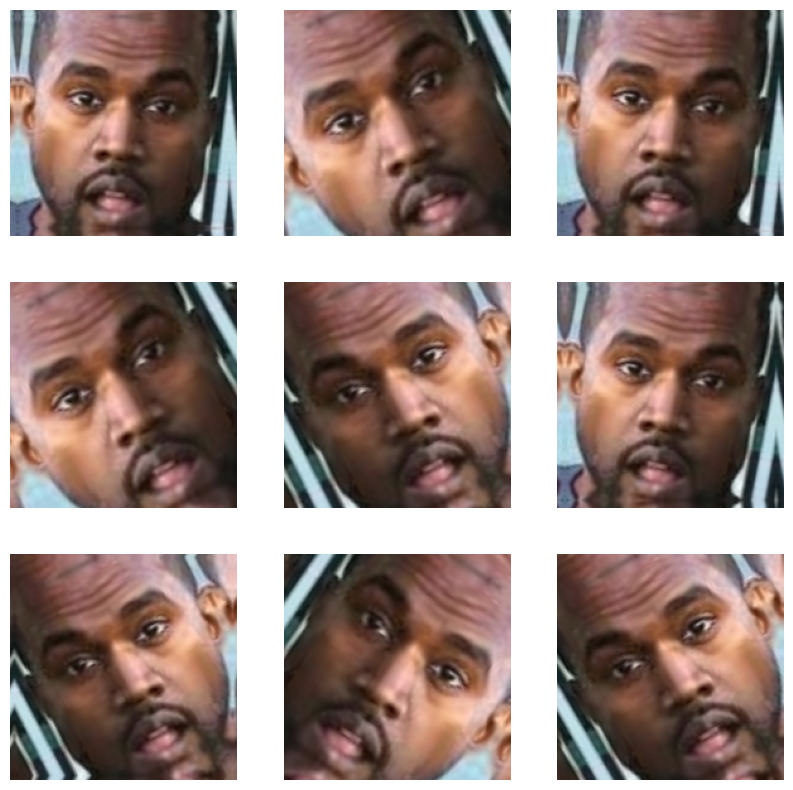

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## **Modelling**

Pada bagian ini, kami membangun *neural network* dengan menggunakan beberapa jenis layer.
1.  ` Layer Conv2D` berfungsi untuk mengenali fitur (bagian) unik dari suatu gambar
2.   `Layer MaxPooling `berfungsi untuk secara progresif mengurangi ukuran spasial dari citra
3. `Layer Flatten` berfungsi untuk mengkonversi citra yang merupakan multidimensi menjadi 1 dimensi agar dapat diproses lebih lanjut di Dense layer
4. `Layer Dense` berfungsi untuk menentukan (memprediksi) citra yang di-*input*, dalam kasus ini memprediksi ekspresi wajah
5. `Layer Dropout` digunakan untuk mencegah ***overfitting***.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name='outputs')
])

In [ ]:
model.build()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 45 # Melakukan training dengan pengulangan (epochs) sebanyak 45 kali
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/45
86/86 [==============================] - 15s 41ms/step - loss: 1.2769 - accuracy: 0.4297 - val_loss: 0.9316 - val_accuracy: 0.5789
Epoch 2/45
86/86 [==============================] - 3s 29ms/step - loss: 0.8760 - accuracy: 0.6024 - val_loss: 0.6911 - val_accuracy: 0.7325
Epoch 3/45
86/86 [==============================] - 3s 32ms/step - loss: 0.7857 - accuracy: 0.6579 - val_loss: 0.6068 - val_accuracy: 0.7602
Epoch 4/45
86/86 [==============================] - 3s 31ms/step - loss: 0.7297 - accuracy: 0.7006 - val_loss: 0.5751 - val_accuracy: 0.7865
Epoch 5/45
86/86 [==============================] - 3s 30ms/step - loss: 0.6809 - accuracy: 0.7112 - val_loss: 0.5174 - val_accuracy: 0.8114
Epoch 6/45
86/86 [==============================] - 3s 29ms/step - loss: 0.6328 - accuracy: 0.7320 - val_loss: 0.4815 - val_accuracy: 0.8202
Epoch 7/45
86/86 [==============================] - 3s 30ms/step - loss: 0.5949 - accuracy: 0.7517 - val_loss: 0.4517 - val_accuracy: 0.8275
Epoch 8/45
8

##**Evaluasi Hasil Training Model**

Pada bagian ini, kami mem*plot*kan **hasil training model** yang telah kita bangun sebelumnya. Bagian ini berfungsi untuk mengetahui apakah model kami ***overfit*** atau ***underfit***.

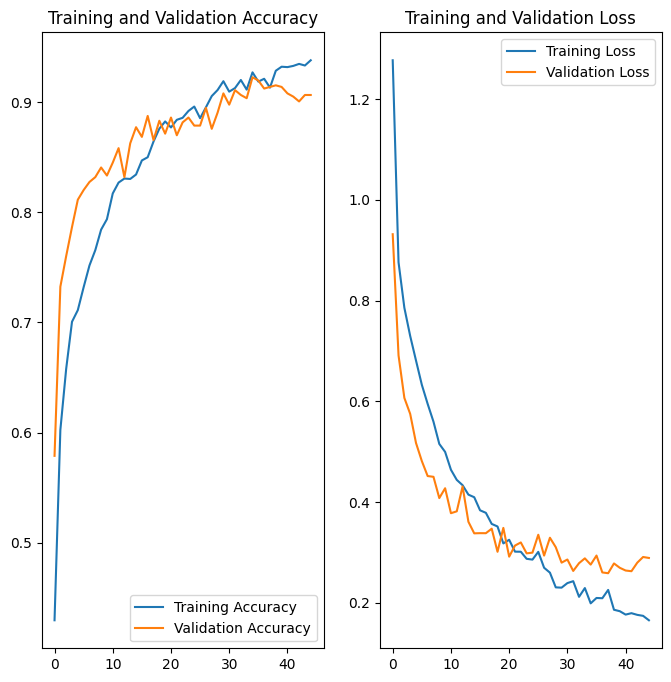

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Dari grafik di atas, dapat disimpulkan bahwa **hasil training model** kami tergolong **cukup bagus** (tidak *overfit* maupun *underfit*)

##**Testing**

Pada bagian ini, kami coba menguji model dengan memasukkan gambar ekspresi wajah yang dari data test yang dipilih secara random

### **Happy**

In [ ]:
# Image Preporcessing
def preprocess_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(180, 180))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

# Fungsi untuk prediksi gambar dan mengembalikan np.max(score)
def predict_and_display(image_path):
    img_array = preprocess_image(image_path)

    predictions = model.predict(img_array, verbose = 0)
    score = tf.nn.softmax(predictions[0])

    return np.max(score)

confidence_scores = []

num_images = 80

image_paths = [os.path.join(happy_path, filename) for filename in os.listdir(happy_path)]

# Secara random memilih 30 image pada data test
selected_image_paths = random.sample(image_paths, num_images)

for selected_image_path in selected_image_paths:
    confidence = predict_and_display(selected_image_path)
    confidence_scores.append(confidence)

average_confidence = np.mean(confidence_scores)
print("Average confidence/accuracy: {:.2f}%".format(100 * average_confidence))

Average confidence/accuracy: 98.36%


1/1 [==============================] - 0s 20ms/step
[[ 5.098984    0.02442875 -1.8647975 ]]


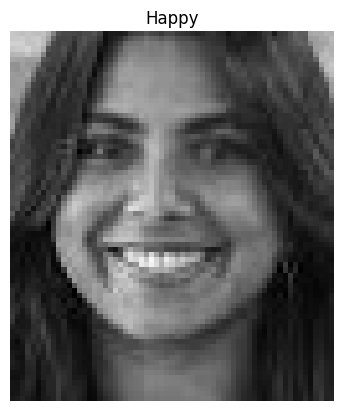

Gambar ini kemungkinan besar merupakan sebuah happy dengan 99.29% confidence


In [ ]:
image_paths = [os.path.join(happy_path, filename) for filename in os.listdir(happy_path)]

# Menampilkan image sad yang dipilih sebagai testing
selected_image_path = random.choice(image_paths)

# Menyesuaikan ukuran image dengan model
img = tf.keras.utils.load_img(selected_image_path, target_size=(180, 180))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Melaukan prediksi dengan model CNN yang telah dibuat
predictions = model.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])

subfolders = ["happy", "sad", "surprise"]

# Menampilkan image "happy" yang dipilih sebagai testing
img = mpimg.imread(selected_image_path)
plt.imshow(img)
plt.axis('off')
plt.title('Happy')
plt.show()

# Menampilkan nilai confidence/akurasi dari hasil prediksi
print(
    "Gambar ini kemungkinan besar merupakan sebuah {} dengan {:.2f}% confidence"
    .format(subfolders[np.argmax(score)], 100 * np.max(score))
)

### **Sad**

In [ ]:
# Image Preporcessing
def preprocess_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(180, 180))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

# Fungsi untuk prediksi gambar dan mengembalikan np.max(score)
def predict_and_display(image_path):
    img_array = preprocess_image(image_path)

    predictions = model.predict(img_array, verbose = 0)
    score = tf.nn.softmax(predictions[0])

    # Menampilkan image test jika dibutuhkan
    # img = mpimg.imread(image_path)
    # plt.imshow(img)
    # plt.axis('off')
    # plt.title('Sad')
    # plt.show()

    return np.max(score)

confidence_scores = []

num_images = 80

image_paths = [os.path.join(sad_path, filename) for filename in os.listdir(sad_path)]

# Secara random memilih 30 image pada data test
selected_image_paths = random.sample(image_paths, num_images)

for selected_image_path in selected_image_paths:
    confidence = predict_and_display(selected_image_path)
    confidence_scores.append(confidence)

average_confidence = np.mean(confidence_scores)
print("Average confidence/accuracy: {:.2f}%".format(100 * average_confidence))

Average confidence/accuracy: 84.98%


1/1 [==============================] - 0s 20ms/step
[[-0.08935846  7.744148   -2.0855563 ]]


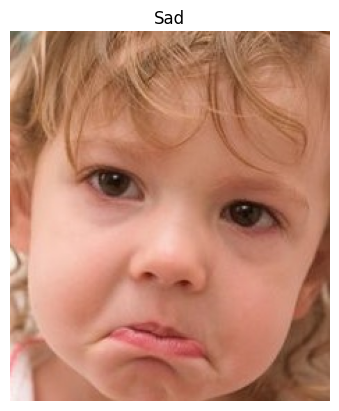

Gambar ini kemungkinan besar merupakan sebuah sad dengan 99.96% confidence


In [ ]:
image_paths = [os.path.join(sad_path, filename) for filename in os.listdir(sad_path)]

# Menampilkan image sad yang dipilih sebagai testing
selected_image_path = random.choice(image_paths)

# Menyesuaikan ukuran image dengan model
img = tf.keras.utils.load_img(selected_image_path, target_size=(180, 180))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Melaukan prediksi dengan model CNN yang telah dibuat
predictions = model.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])

subfolders = ["happy", "sad", "surprise"]

# Menampilkan image "sad" yang dipilih sebagai testing
img = mpimg.imread(selected_image_path)
plt.imshow(img)
plt.axis('off')
plt.title('Sad')
plt.show()

# Menampilkan nilai confidence/akurasi dari hasil prediksi
print(
    "Gambar ini kemungkinan besar merupakan sebuah {} dengan {:.2f}% confidence"
    .format(subfolders[np.argmax(score)], 100 * np.max(score))
)

### **Surprise**

In [ ]:
# Image Preporcessing
def preprocess_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(180, 180))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

# Fungsi untuk prediksi gambar dan mengembalikan np.max(score)
def predict_and_display(image_path):
    img_array = preprocess_image(image_path)

    predictions = model.predict(img_array, verbose = 0)
    score = tf.nn.softmax(predictions[0])

    # Menampilkan image test jika dibutuhkan
    # img = mpimg.imread(image_path)
    # plt.imshow(img)
    # plt.axis('off')
    # plt.title('Surprise')
    # plt.show()

    return np.max(score)

confidence_scores = []

num_images = 80

image_paths = [os.path.join(surprise_path, filename) for filename in os.listdir(surprise_path)]

# Secara random memilih 30 image pada data test
selected_image_paths = random.sample(image_paths, num_images)

for selected_image_path in selected_image_paths:
    confidence = predict_and_display(selected_image_path)
    confidence_scores.append(confidence)

average_confidence = np.mean(confidence_scores)
print("Average confidence/accuracy: {:.2f}%".format(100 * average_confidence))

Average confidence/accuracy: 89.79%


1/1 [==============================] - 0s 21ms/step
[[-2.9845676 -2.6381798  7.262747 ]]


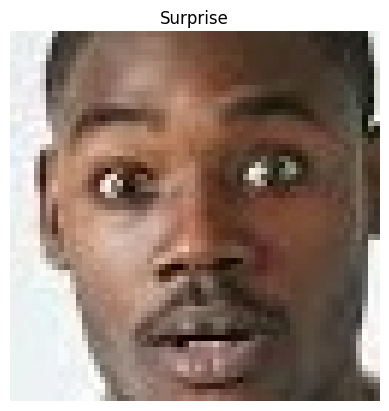

Gambar ini kemungkinan besar merupakan sebuah surprise dengan 99.99% confidence


In [ ]:
image_paths = [os.path.join(surprise_path, filename) for filename in os.listdir(surprise_path)]

# Menampilkan image sad yang dipilih sebagai testing
selected_image_path = random.choice(image_paths)

# Menyesuaikan ukuran image dengan model
img = tf.keras.utils.load_img(selected_image_path, target_size=(180, 180))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Melaukan prediksi dengan model CNN yang telah dibuat
predictions = model.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])

subfolders = ["happy", "sad", "surprise"]

# Menampilkan image "surprise" yang dipilih sebagai testing
img = mpimg.imread(selected_image_path)
plt.imshow(img)
plt.axis('off')
plt.title('Surprise')
plt.show()

# Menampilkan nilai confidence/akurasi dari hasil prediksi
print(
    "Gambar ini kemungkinan besar merupakan sebuah {} dengan {:.2f}% confidence"
    .format(subfolders[np.argmax(score)], 100 * np.max(score))
)

## **Saving the Model**

In [ ]:
model.save('my_model_compvis.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files
files.download('my_model_compvis.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Upload Model Jika dibutuhkan
# from google.colab import files
# uploaded = files.upload()

## **Loading the Model**

In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the file
model = load_model('my_model_compvis.h5')

In [ ]:
# Upload Gambar
from google.colab import files
uploaded = files.upload()

Saving real_image_test.jpg to real_image_test.jpg


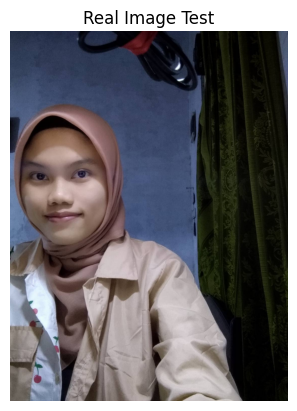

1/1 [==============================] - 0s 143ms/step
Gambar ini kemungkinan besar merupakan sebuah happy dengan 97.92% confidence


In [ ]:
image_path = 'real_image_test.jpg'

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.title('Real Image Test')
plt.show()


predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Gambar ini kemungkinan besar merupakan sebuah {} dengan {:.2f}% confidence"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

### **Kesimpulan**

1. Akurasi *training* yang diperoleh model CNN sebesar 93,79%
2. Akurasi validasi yang diperoleh dari model CNN sebesar 90,64%.
2. Rata-rata akurasi testing dari model CNN sebesar 91,04%
6. `Hasil prediksi model CNN menggunakan gambar asli (real) memiliki confidence sebesar 97,92%`


**Hasil prediksi di atas dan dari evaluasi hasil model tergolong sangat bagus** untuk klasifikasi citra dengan dataset yang cukup besar.


### **Saran**

* Akurasi dari model dapat ditingkatkan dengan membuat model yang lebih kompleks lagi (i.e. menambahkan layer), tetapi hal ini akan `membutuhkan daya komputasi yang jauh lebih besar juga `.

* Jika dilihat dari data gambar yang ada, **ada beberapa gambar yang kualitasnya cukup buruk** (tidak jelas).

* Oleh karena itu, akurasi dari model juga dapat ditingkatkan dengan menambah atau `mengganti data gambar tersebut dengan gambar yang lebih bagus (jelas)`.